# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-11

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file format: .tif, .png, .jpg
> Output file formats: None currently  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl  

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [2]:
# Importing dependencies
import imageio.v3 as iio
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import ipympl
%matplotlib widget

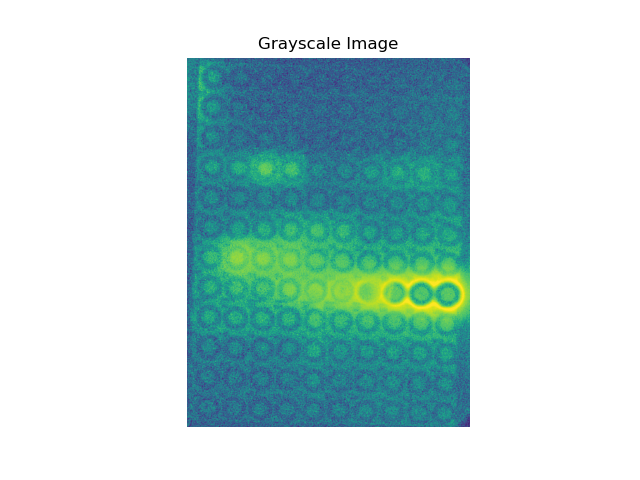

In [53]:
load=iio.imread("test_images\halo_spots_1.tif")

# Check if image has an alpha value and convert image to RGB.
if load.shape[2]==4:
    raw_img=skimage.color.rgb2gray(load[:,:,0:3])

# Convert RGB images to grayscale.
elif load.shape[2]==3:
    raw_img=skimage.color.rgb2gray(load)

# Invert the intensity values. Comment out if you do not wish to invert the image.
raw_img=skimage.util.invert(raw_img)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


,x_coord,y_coord,radius,hough_peak_int
0,396,659,21,0.664062
1,484,1237,21,0.632812
2,391,891,21,0.625000
3,401,430,23,0.610294
4,102,191,20,0.591667
5,587,1011,21,0.585938
6,85,994,21,0.585938
7,898,791,22,0.585938
8,799,788,21,0.585938
9,189,885,20,0.575000


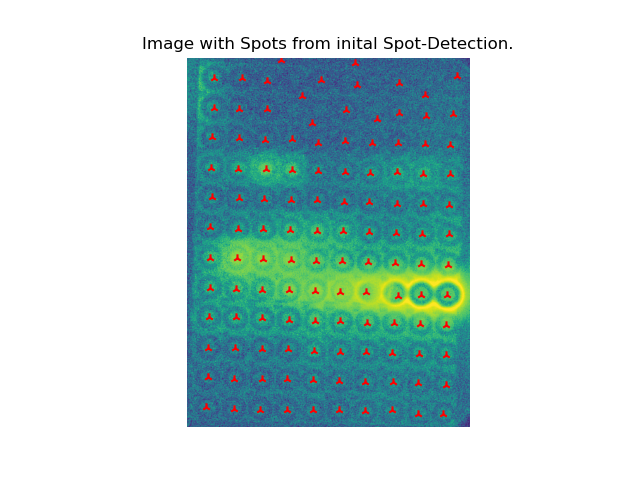

In [56]:
# Edge detection in Image using the Canny method.
histeq_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(raw_img),skimage.morphology.disk(50))
edges=skimage.feature.canny(
    image=histeq_img,
    sigma=10,
    low_threshold=0.001,
    high_threshold=0.001
    )

# Range of Radii that are tested during inital spotdetection.
tested_radii=np.arange(20,31)

# Hough transform for a circle of the edge-image and peak detection to find circles in earlier defined range of radii.
spot_hough=skimage.transform.hough_circle(edges,tested_radii)
accums,spot_x,spot_y,spot_rad=skimage.transform.hough_circle_peaks(
    hspaces=spot_hough,
    radii=tested_radii,
    total_num_peaks=120,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.3*spot_hough.max()
    )

# Storing results in DataFrame.
det_spot=pd.DataFrame({"x_coord":spot_x,"y_coord":spot_y,"radius":spot_rad,"hough_peak_int":accums})

# Displaying image with initally detected spots.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Image with Spots from inital Spot-Detection.")
ax.scatter(spot_x,spot_y,marker="2",c="red")

# Displaying the first 10 Rows of the Dataframe.
det_spot.head(10)

[(1417.0, 0.0), (0.0, 1082.0)]

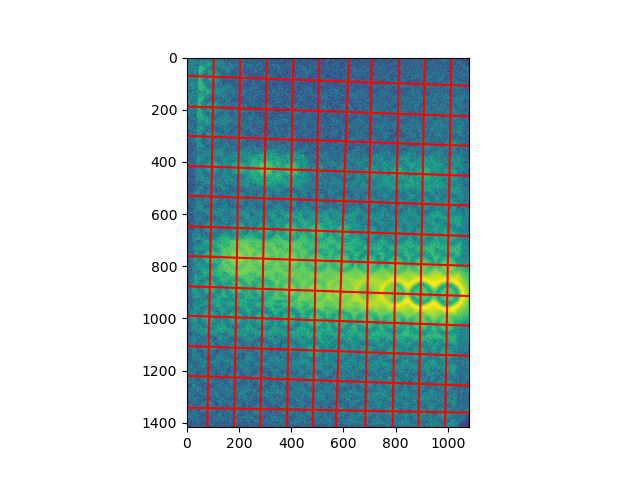

In [74]:
def draw_spot(image,x_coord,y_coord,radius,value):
    rr,cc=skimage.draw.disk((y_coord,x_coord),radius)
    try:
        image[rr,cc]=value
    except:
        print(f"Spot at Coordinates ({x_coord}, {y_coord}) could not be drawn: Out of Bounds.")
    return image

dot_img=np.zeros(raw_img.shape)
for idx in det_spot.index:
    dot_img=draw_spot(dot_img,det_spot.loc[idx,"x_coord"],det_spot.loc[idx,"y_coord"],5,255)

def detect_grid(img,max_tilt):
    line_img,ang,dist=skimage.transform.hough_line(img)
    line_img[:,np.r_[max_tilt:89-max_tilt,91+max_tilt:180-max_tilt]]=0
    accum,angle,distance=skimage.transform.hough_line_peaks(line_img,ang,dist,min_distance=80,threshold=0.2*line_img.max())
    return angle,distance

fig,ax=plt.subplots()
ax.imshow(raw_img)
x,y=detect_grid(dot_img,5)
for b,c in zip(x,y):
    (x0, y0) = c * np.array([np.cos(b), np.sin(b)])
    ax.axline((x0, y0), slope=np.tan(b+np.pi/2),c="red")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])